In [2]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

### Data Collection

All of the data files used in this project was downloaded from the following webpage:

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [3]:
# Load trip data and location lookup table to dataframes
trip_df = pd.read_parquet('./data/yellow_tripdata_2025-01.parquet')
taxi_zone_df = pd.read_csv('./data/taxi_zone_lookup.csv')

# Additional Data Source 
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
# payment_type : A numeric code signifying how the passenger paid for the trip.
payment_type_lookup = {
    0:'Flex Fare trip',
    1:'Credit card',
    2:'Cash',
    3:'No charge',
    4:'Dispute',
    5:'Unknown',
    6:'Voided trip',
}

In [4]:
# Merge location data for PU and DO locations
df = trip_df.merge(
    taxi_zone_df,
    how='left',
    left_on='PULocationID',
    right_on='LocationID'
).rename(columns=lambda col: col if col in trip_df.columns else f"PU_{col}")

df = df.merge(
    taxi_zone_df,
    how='left',
    left_on='DOLocationID',
    right_on='LocationID'
).rename(columns=lambda col: col if col in df.columns else f"DO_{col}")
df = df.drop(columns=['PULocationID','DOLocationID'])
df = df.rename(columns = {'Airport_fee':'airport_fee'})
print(df.shape)
df.head()

(3475226, 25)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,...,congestion_surcharge,airport_fee,PU_LocationID,PU_Borough,PU_Zone,PU_service_zone,DO_LocationID,DO_Borough,DO_Zone,DO_service_zone
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,1,10.0,3.5,...,2.5,0.0,229,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,1,5.1,3.5,...,2.5,0.0,236,Manhattan,Upper East Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,1,5.1,3.5,...,2.5,0.0,141,Manhattan,Lenox Hill West,Yellow Zone,141,Manhattan,Lenox Hill West,Yellow Zone
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,2,7.2,1.0,...,0.0,0.0,244,Manhattan,Washington Heights South,Boro Zone,244,Manhattan,Washington Heights South,Boro Zone
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,2,5.8,1.0,...,0.0,0.0,244,Manhattan,Washington Heights South,Boro Zone,116,Manhattan,Hamilton Heights,Boro Zone


In [5]:
# Filter for relevant features
features = [
    'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
    'payment_type', 'fare_amount', 'extra',
    'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
    'total_amount', 'congestion_surcharge', 'airport_fee', 
    'PU_LocationID', 'PU_Borough', 'PU_Zone', 'PU_service_zone',
    'DO_LocationID', 'DO_Borough', 'DO_Zone', 'DO_service_zone'
]
df = df[features].copy()

# Convert datetime columns
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

### Rule Based Anomaly Detection

In [6]:
# RULE-BASED ANOMALY FLAGS
df['anomaly_negative_fare'] = df['fare_amount'] < 0
df['anomaly_zero_fare_long_trip'] = (df['fare_amount'] == 0) & (df['trip_distance'] > 1)
df['anomaly_short_trip_high_fare'] = (df['fare_amount'] > 100) & (df['trip_distance'] < 1)
df['anomaly_duration'] = (df['trip_duration'] < 1) | (df['trip_duration'] > 180)
df['anomaly_tip_but_cash'] = (df['tip_amount'] > 0) & (df['payment_type'] == 2)  # 2 = cash
df['anomaly_passenger_count'] = (df['passenger_count'] < 1) | (df['passenger_count'] > 6)
df['anomaly_total_vs_fare'] = df['total_amount'] < df['fare_amount']
df['anomaly_airport_fee_wrong_location'] = (df['airport_fee'] > 0) & (~df['PU_LocationID'].isin([1, 132, 138])) # Newark, JFK, LaGuardia

In [7]:
# Count total anomalies
anomaly_columns = [col for col in df.columns if col.startswith('anomaly_')]
df['anomaly_score'] = df[anomaly_columns].sum(axis=1)
df['is_anomaly'] = df['anomaly_score'] > 0

# Show summary
print("Total records:", len(df))
print("Anomalous trips:", df['is_anomaly'].sum())
print("Percentage of Anomalous records:", round(df['is_anomaly'].sum() / len(df) * 100,2), '%')

# save anomalies to .csv file
df[df['is_anomaly']].to_csv("detected_taxi_anomalies.csv", index=False)

Total records: 3475226
Anomalous trips: 211138
Percentage of Anomalous records: 6.08 %


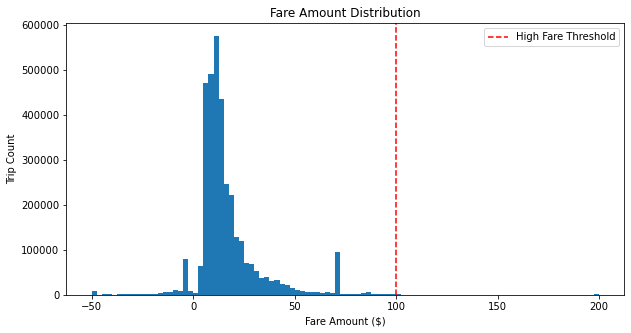

In [8]:
# Plotting
plt.figure(figsize=(10, 5))
df['fare_amount'].clip(lower=-50, upper=200).hist(bins=100)
plt.axvline(100, color='red', linestyle='dashed', label='High Fare Threshold')
plt.title("Fare Amount Distribution")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Trip Count")
plt.legend()
plt.grid()
plt.show()



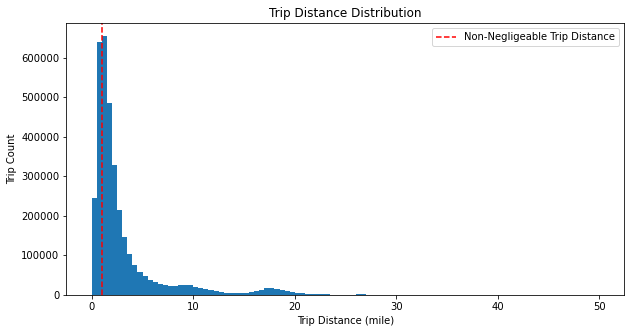

In [9]:
# Plotting
plt.figure(figsize=(10, 5))
df['trip_distance'].clip(lower=-1, upper=50).hist(bins=100)
plt.axvline(1, color='red', linestyle='dashed', label='Non-Negligeable Trip Distance')
plt.title("Trip Distance Distribution")
plt.xlabel("Trip Distance (mile)")
plt.ylabel("Trip Count")
plt.legend()
plt.grid()
plt.show()


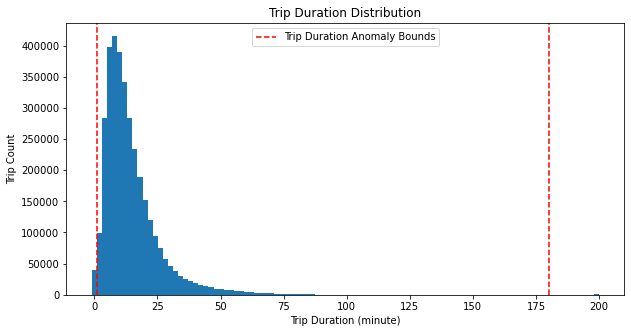

In [10]:
# Plotting
plt.figure(figsize=(10, 5))
df['trip_duration'].clip(lower=-1, upper=200).hist(bins=100)
plt.axvline(1, color='red', linestyle='dashed')
plt.axvline(180, color='red', linestyle='dashed')
plt.title("Trip Duration Distribution")
plt.xlabel("Trip Duration (minute)")
plt.ylabel("Trip Count")
plt.legend(['Trip Duration Anomaly Bounds'], loc = 'upper center')
plt.grid()
plt.show() 


### Isolation Forest

In [11]:
# Select numeric features for modeling
ml_features = [
    'trip_distance', 'trip_duration', 'fare_amount',
    'tip_amount', 'total_amount', 'passenger_count'
]

# Drop NA and scale
df_ml = df[ml_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ml)

# Fit Isolation Forest
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_ml['unsupervised_anomaly'] = iso.fit_predict(X_scaled)  # -1 is anomaly, 1 is normal
df_ml['unsupervised_anomaly'] = df_ml['unsupervised_anomaly'] == -1  # convert to True/False

# Map back to main dataframe by index
df['unsupervised_anomaly'] = False
df.loc[df_ml.index, 'unsupervised_anomaly'] = df_ml['unsupervised_anomaly']

# Combine rule-based and ML-based
df['final_anomaly'] = df['is_anomaly'] | df['unsupervised_anomaly']

print("Anomalies detected by Isolation Forest:", df['unsupervised_anomaly'].sum())
print("Total combined anomalies (rules + ML):", df['final_anomaly'].sum())

# Save combined anomalies
df[df['final_anomaly']].to_csv("final_detected_taxi_anomalies.csv", index=False)


Anomalies detected by Isolation Forest: 29351
Total combined anomalies (rules + ML): 231809
